In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from cs771 import genSyntheticData as gsd
from cs771 import plotData as pd
from matplotlib import pyplot as plt
import time as tm
import random

d = 2 
n = 60

muPos1 = np.array( [-5,5] )
muPos2 = np.array( [1,-5] )
muNeg = np.array( [-5,-5] )
r = 3

nOutlier = n//10
tmp1 = gsd.genSphericalData( d, n, muPos1, r)
tmp2 = gsd.genSphericalData( d, nOutlier, muPos2, r//3 )
XPos = np.vstack( (tmp1, tmp2) )
XNeg = gsd.genSphericalData( d, n, muNeg, r )
yPos = np.ones( (n + nOutlier,) )
yNeg = -np.ones( (n,) )
X = np.vstack( (XPos, XNeg) )
y = np.concatenate( (yPos, yNeg) )

nSV =  26  out of  126 data points


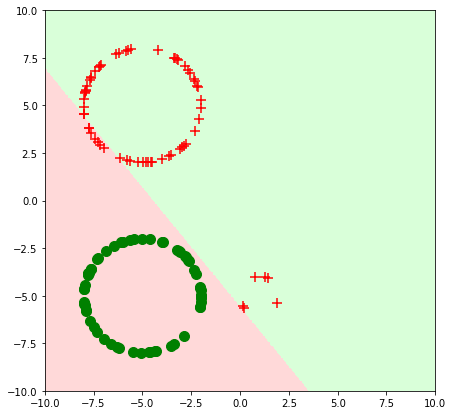

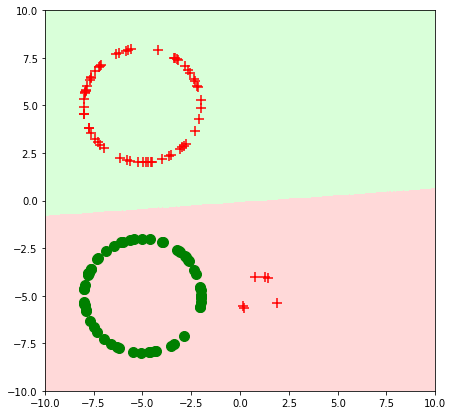

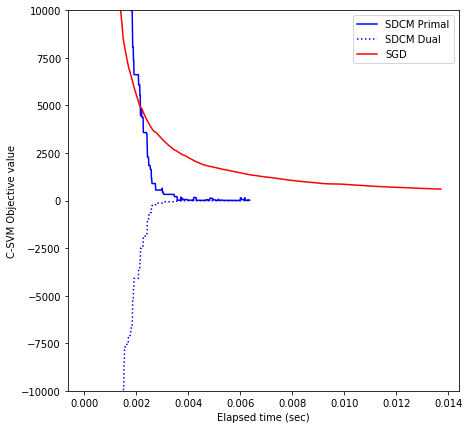

In [3]:
def getCyclicCoord( currentCoord ):
    if currentCoord >= n-1 or currentCoord < 0:
        return 0
    else:
        return currentCoord + 1

def getRandCoord( currentCoord ):
    return random.randint( 0, n-1 )

def getRandpermCoord( currentCoord ):
    global randperm, randpermInner
    if randpermInner >= n-1 or randpermInner < 0 or currentCoord < 0:
        randpermInner = 0
        randperm = np.random.permutation( y.size )
        return randperm[randpermInner]
    else:
        randpermInner = randpermInner + 1
        return randperm[randpermInner]

# Get the CSVM objective value in order to plot convergence curves
def getCSVMObjVal( theta ):
    w = theta[0:-1]
    b = theta[-1]
    hingeLoss = np.maximum( 1 - np.multiply( (X.dot( w ) + b), y ), 0 )
    return 0.5 * w.dot( w ) + C * np.sum(hingeLoss)

def getCSVMObjValDual( alpha, w, b ):
    # Recall that b is supposed to be treated as the last coordinate of w
    return np.sum(alpha) - 0.5 * np.square( np.linalg.norm( w ) ) - 0.5 * b * b

def doSDCM( getCoordFunc, init, horizon = 10 ):
    primalObjValSeries = np.zeros( (horizon,) )
    dualObjValSeries = np.zeros( (horizon,) )
    timeSeries = np.zeros( (horizon,) )
    totTime = 0
    
    # Initialize model as well as some bookkeeping variables
    alpha = init
    alphay = np.multiply( alpha, y )
    # Initialize the model vector using the equations relating primal and dual variables
    w = X.T.dot( alphay )
    # Recall that we are imagining here that the data points have one extra dimension of ones
    # This extra dimension plays the role of the bias in this case
    b = alpha.dot( y )
    # Calculate squared norms taking care that we are appending an extra dimension of ones
    normSq = np.square( np.linalg.norm( X, axis = 1 ) ) + 1
    # We have not made any choice of coordinate yet
    i = -1
    
    for t in range( horizon ):
        tic = tm.perf_counter()
        
        i = getCoordFunc( i )
        x = X[i,:]
        
        # Find the unconstrained new optimal value of alpha_i
        newAlphai =  alpha[i] + (1 - y[i] * (x.dot(w) + b)) / normSq[i]
        # Make sure that the constraints are satisfied
        if newAlphai > C:
            newAlphai = C
        if newAlphai < 0:
            newAlphai = 0
        
        # Update the model vector and bias values
        # Takes only O(d) time to do so :)
        w = w + (newAlphai - alpha[i]) * y[i] * x
        b = b + (newAlphai - alpha[i]) * y[i]
        
        alpha[i] = newAlphai

        toc = tm.perf_counter()
        totTime = totTime + (toc - tic)
        
        primalObjValSeries[t] = getCSVMObjVal( np.append( w, b ) )
        dualObjValSeries[t] = getCSVMObjValDual( alpha, w, b )
        timeSeries[t] = totTime
        
    print( "nSV = ", np.sum( alpha > C/100 ), " out of ", y.size, "data points" )    
    return (np.append( w, b ), primalObjValSeries, dualObjValSeries, timeSeries)

# Get a stochastic gradient for the CSVM objective
# Choose a random data point per iteration
def getCSVMSGrad( theta ):
    w = theta[0:-1]
    b = theta[-1]
    n = y.size
    i = random.randint( 0, n-1 )
    x = X[i,:]
    discriminant = (x.dot( w ) + b) * y[i]
    g = 0
    if discriminant < 1:
        g = -1
    delb = C * n * g * y[i]
    delw = w + C * n * (x * g) * y[i]
    return np.append( delw, delb )

# Quite standard for strongly convex but non-smooth objectives like CSVM
def getStepLength( grad, t ):
    return eta/(t+1)

# Given a gradient oracle, a step length oracle, an initialization,
# perform GD for a specified number of steps (horizon)
def doGD( gradFunc, stepFunc, init, horizon = 10 ):
    objValSeries = np.zeros( (horizon,) )
    timeSeries = np.zeros( (horizon,) )
    totTime = 0
    theta = init
    cumulative = init
    for t in range( horizon ):
        tic = tm.perf_counter()
        delta = gradFunc( theta )
        theta = theta - stepFunc( delta, t+1 ) * delta
        cumulative = cumulative + theta
        toc = tm.perf_counter()
        totTime = totTime + (toc - tic)
        objValSeries[t] = getCSVMObjVal( cumulative/(t+2) )
        timeSeries[t] = totTime
    return (cumulative/(horizon+1), objValSeries, timeSeries)

def mySVM( X ):
    return X.dot(w) + b

randperm = np.random.permutation( y.size )
randpermInner = -1
C = 1
eta = 2

# SDCA outperforms SGD handily when dealing with more challenging problems e.g. those with large
# values of C. SGD can get very sluggish with difficult problems and stop making progress

# SCDA performs very well with the getRandpermCoord method of choosing coordinates as compared to
# getRandCoord or getCyclicCoord. Random Permutations are the default method in liblinear as well
(theta_SDCM, primal_SDCM, dual_SDCM, time_SDCM) = doSDCM( getRandpermCoord, C * np.ones( (y.size,) ), horizon = 500 )
(theta_SGD, obj_SGD, time_SGD) = doGD( getCSVMSGrad, getStepLength, np.zeros( (d+1,) ), horizon = 500 )

w = theta_SDCM[0:-1]
b = theta_SDCM[-1]

fig = pd.getFigure( 7, 7 )
pd.shade2D( mySVM, fig, mode = 'batch', xlim = 10, ylim = 10 )
pd.plot2D( XPos, fig, color = 'r', marker = '+' )
pd.plot2D( XNeg, fig, color = 'g', marker = 'o' )
plt.show()

w = theta_SGD[0:-1]
b = theta_SGD[-1]

fig = pd.getFigure( 7, 7 )
pd.shade2D( mySVM, fig, mode = 'batch', xlim = 10, ylim = 10 )
pd.plot2D( XPos, fig, color = 'r', marker = '+' )
pd.plot2D( XNeg, fig, color = 'g', marker = 'o' )
plt.show()

fig4 = pd.getFigure( 7, 7 )
plt.figure( fig4.number )
plt.plot( time_SDCM, primal_SDCM, color = 'b', linestyle = '-', label = "SDCM Primal Obj Val" )
plt.plot( time_SDCM, dual_SDCM, color = 'b', linestyle = ':', label = "SDCM Dual Obj Val" )
plt.plot( time_SGD, obj_SGD, color = 'r', linestyle = '-', label = "SGD" )
plt.legend()
plt.xlabel( "Elapsed time (sec)" )
plt.ylabel( "C-SVM Objective value" )
plt.ylim( -10000, 10000 )
plt.show()